# Linguaggio Stan

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [2]:
%run ../../config.py # Import the configuration settings
import itertools
import logging
import statistics as stat
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

## Introduzione

Nel presente capitolo, presenteremo un linguaggio di programmazione probabilistica denominato [Stan](http://mc-stan.org/). Stan consente di estrarre campioni da distribuzioni di probabilità mediante la costruzione di una catena di Markov, la cui distribuzione di equilibrio (o stazionaria) coincide con la distribuzione desiderata. Il nome del linguaggio deriva da uno dei pionieri del metodo Monte Carlo, Stanislaw Ulam. Un'introduzione dettagliata al linguaggio Stan è fornita in @appendix-cmdstanpy. In questo capitolo, utilizzeremo Stan per fare inferenza su una proporzione.

Il linguaggio di programmazione probabilistica Stan è compatibile con diverse piattaforme e offre varie interfacce (R, Python, Julia). In questo corso, useremo CmdStanPy, un'interfaccia per Stan pensata per gli utenti di Python. CmdStanPy è un pacchetto puramente in Python3 che è un wrapper di CmdStan, l'interfaccia a riga di comando per Stan scritta in C++. Pertanto, oltre a Python3, CmdStanPy richiede un toolchain C++ per compilare ed eseguire i modelli Stan.

La procedura per [installare](https://mc-stan.org/cmdstanpy/installation.html) CmdStanPy e i componenti sottostanti di CmdStan dal repository conda-forge è descritta nel capitolo @sec-virtual-env.

## Inferenza Bayesiana e Metodi MCMC

L'inferenza bayesiana, impiegata per la stima dei parametri, la previsione e la valutazione della probabilità di eventi, si basa sulle aspettative a posteriori. Queste aspettative si configurano come integrali multidimensionali nello spazio dei parametri. Stan, un software all'avanguardia per l'analisi statistica, si avvale del metodo Monte Carlo per risolvere questi integrali complessi. I metodi Monte Carlo sfruttano il campionamento casuale per affrontare integrali ad alta dimensionalità.

Tuttavia, per la maggior parte dei problemi bayesiani, non è possibile utilizzare i metodi Monte Carlo standard, poiché non è fattibile generare campioni indipendenti dalla densità a posteriori di interesse, fatta eccezione per modelli estremamente semplici con prior coniugati. Di conseguenza, è necessario ricorrere ai metodi Monte Carlo a Catena di Markov (MCMC), che producono campioni correlati tra loro. Stan implementa il Monte Carlo Hamiltoniano (HMC), il metodo MCMC più efficiente e scalabile per le densità target. Altri metodi, come il Metropolis-Hastings e il campionamento di Gibbs, risultano più semplici ma meno efficienti dell'HMC.

## Stan e la Programmazione Probabilistica

Stan si configura come un linguaggio di programmazione probabilistica (PPL) concepito per definire modelli statistici complessi e effettuare inferenze su di essi. Un PPL consente di esprimere modelli probabilistici in modo conciso e di utilizzare algoritmi avanzati per l'inferenza. Ciò risulta particolarmente utile nell'inferenza bayesiana, dove si aggiornano le distribuzioni a priori con dati osservati per ottenere distribuzioni a posteriori.

### Struttura di un Programma Stan

Un programma Stan richiede la specificazione di variabili e parametri, definendo le distribuzioni a priori dei parametri del modello statistico e la funzione di verosimiglianza. In sostanza, un programma Stan descrive l'interazione tra dati e parametri e le distribuzioni probabilistiche che li governano. Questo consente di effettuare inferenze sulle distribuzioni a posteriori dei parametri del modello, dedotte dai dati osservati e dalle distribuzioni a priori.

### Esecuzione di un Programma Stan

Un programma Stan utilizza metodi di inferenza avanzati:

- **Campionamento MCMC**: Stan impiega metodi come il Monte Carlo a Catena di Markov per generare campioni dalle distribuzioni a posteriori.
- **Inferenza Variazionale**: Un metodo approssimativo che fornisce stime delle distribuzioni a posteriori.
- **Approssimazione di Laplace**: Un ulteriore metodo approssimativo per l'inferenza.

Stan è accessibile attraverso vari linguaggi di programmazione e strumenti di analisi open-source, tra cui Python, R e Julia, ed è compatibile con gli strumenti di analisi bayesiana integrati in questi linguaggi. È inoltre disponibile in ambienti come Mathematica, Stata e MATLAB, sebbene queste interfacce siano meno complete.

## Simulazione in Avanti e Problema Inverso

Stan genera dati attraverso procedure pseudo-casuali, applicabili sia per simulazioni in avanti che per risolvere il problema inverso.

### Simulazione in Avanti

La simulazione in avanti consiste nella generazione di dati simulati a partire da un insieme di parametri noti di un modello probabilistico. In altri termini, date determinate assunzioni sui parametri di un modello, si utilizza la simulazione in avanti per prevedere i possibili risultati.

Ad esempio, consideriamo uno studio clinico con $N$ soggetti e una probabilità $\theta$ di esito positivo per ciascun soggetto. Conoscendo il valore di $\theta$ e il numero di soggetti $N$, possiamo impiegare una distribuzione binomiale per simulare il numero di pazienti che avranno un esito positivo. Questo processo ci consente di generare dati che riflettono le nostre assunzioni sui parametri del modello.

In notazione statistica, questo si esprime come:

$$
Y \sim \text{Binomiale}(N, \theta)
$$

dove $Y$ rappresenta il numero di esiti positivi su $N$ pazienti, con probabilità $\theta$ di esito positivo per ciascun paziente.

#### Esempio di Simulazione in Avanti

Supponiamo di avere $N = 100$ soggetti in uno studio clinico e un tasso di successo $\theta = 0.3$. Possiamo simulare un risultato $Y$ generando casualmente il numero di soggetti con esito positivo. Utilizzando una distribuzione binomiale, possiamo calcolare la probabilità di ottenere esattamente $y$ esiti positivi su $N$ tentativi:

$$
p(Y = y \mid N, \theta) = \binom{N}{y} \cdot \theta^y \cdot (1 - \theta)^{N - y}
$$

Questa espressione ci permette di calcolare la probabilità di ottenere un certo numero di successi, dato il numero di soggetti e la probabilità di successo.

### Il Problema Inverso

Il problema inverso consiste nella stima dei parametri del modello, come la probabilità di successo $\theta$, dato un insieme di dati osservati. Supponiamo di avere i seguenti dati: $N = 100$ soggetti e $y = 32$ esiti positivi. L'obiettivo è stimare $\theta$, la probabilità di successo.

Nell'approccio bayesiano, si inizia specificando una distribuzione a priori per $\theta$. Supponiamo di utilizzare una distribuzione Beta($\alpha$, $\beta$) come prior per $\theta$, dove $\alpha$ e $\beta$ sono parametri scelti in base alle conoscenze precedenti. La distribuzione a posteriori di $\theta$ data l'osservazione $y$ è ancora una distribuzione Beta, ma con parametri aggiornati:

$$
\theta \mid y \sim \text{Beta}(\alpha + y, \beta + N - y)
$$

Ad esempio, scegliendo una distribuzione a priori non informativa con $\alpha = 1$ e $\beta = 1$, la distribuzione a posteriori diventa:

$$
\theta \mid y \sim \text{Beta}(1 + 32, 1 + 100 - 32) = \text{Beta}(33, 69)
$$

Questa distribuzione a posteriori fornisce una stima aggiornata della probabilità di successo $\theta$ considerando i dati osservati. Utilizzando Stan, è possibile ottenere campioni da questa distribuzione a posteriori per calcolare statistiche riassuntive e effettuare previsioni.

In sintesi, la simulazione in avanti e il problema inverso rappresentano due approcci complementari: la simulazione in avanti genera dati simulati da parametri noti, mentre il problema inverso stima i parametri del modello dai dati osservati.

## Un Primo Programma in Stan

### Generazione di Dati Casuali

Supponiamo di voler generare dei valori casuali $ Y $ da una distribuzione binomiale con parametri $ N $ e $ \theta $. Ad esempio, possiamo impostare $ \theta = 0.3 $, per rappresentare una probabilità del 30% di un esito positivo (in statistica, il termine 'successo' indica un esito positivo), e possiamo impostare $ N = 100 $. Il seguente programma Stan può essere utilizzato per generare valori di $ Y $ compresi tra 0 e 100.

```stan
data {
  int<lower=0> N;
  real<lower=0, upper=1> theta;
}

generated quantities {
  int<lower=0, upper=N> y;
  y = binomial_rng(N, theta);
}
```

### Organizzazione di un Programma Stan

La prima cosa da notare è che un programma Stan è organizzato in blocchi. Qui abbiamo due blocchi: un _blocco dei dati_ contenente le dichiarazioni delle variabili che devono essere fornite come dati e un _blocco delle quantità generate_, che non solo dichiara variabili ma assegna loro un valore. In questo programma Stan, la variabile `y` viene assegnata come risultato di una singola estrazione da una distribuzione $\textrm{binomiale}(N, \theta)$, che Stan fornisce attraverso la funzione `binomial_rng`.

### Tipi di Variabili in Stan

La seconda cosa da notare è che tutte le variabili in un programma Stan sono dichiarate con tipi specifici. Stan utilizza la _tipizzazione statica_, il che significa che, a differenza di Python o R, il tipo di una variabile è dichiarato nel programma prima del suo utilizzo, piuttosto che essere determinato al momento dell'esecuzione in base al valore assegnato. Una volta dichiarato, il tipo di una variabile non cambia mai. Stan utilizza anche la _tipizzazione forte_, il che significa che, a differenza di C o C++, non è possibile aggirare le restrizioni di tipo per accedere direttamente alla memoria.

Il programma dichiara tre variabili: `N` e `y` di tipo `int` (interi) e `theta` di tipo `real` (numeri reali). Nei computer, gli interi hanno limiti precisi e i numeri reali possono avere errori di calcolo. Stan utilizza numeri reali con precisione doppia (64 bit) secondo lo standard IEEE 754, tranne in alcune operazioni ottimizzate che possono perdere un po' di precisione.

### Vincoli sui Tipi

Un tipo di variabile può avere dei vincoli. Poiché `N` è un conteggio, deve essere maggiore o uguale a zero, cosa che indichiamo con il vincolo `lower=0`. Allo stesso modo, la variabile `y`, che rappresenta il numero di esiti positivi su `N`, deve essere compresa tra 0 e `N` (inclusi); questo è indicato con il vincolo `lower=0, upper=N`. Infine, la variabile `theta` è un numero reale e deve essere compresa tra 0 e 1, cosa che indichiamo con il vincolo `lower=0, upper=1`. Anche se tecnicamente i limiti per i numeri reali sono aperti, in pratica possiamo ottenere valori di 0 o 1 a causa di errori di arrotondamento nei calcoli.

### Esecuzione del Programma Stan

La funzione `cmdstan_model()` crea un nuovo oggetto `CmdStanModel` a partire da un file contenente un programma Stan. In background, CmdStan traduce un programma Stan in C++ e creare un eseguibile compilato.

In [3]:
model = CmdStanModel(stan_file='../../stan/binomial-rng.stan')

Durante l'esecuzione, il programma Stan compilato richiede i valori di `N` e `theta`. Ad ogni iterazione, il programma campiona un valore di `y` utilizzando il suo generatore di numeri pseudocasuali integrato. I valori di `N` e `theta` devono essere forniti in un dizionario Python.

In [4]:
N = 100
theta = 0.3
data = {'N': N, 'theta': theta}

Infine campioniamo dal modello utilizzando il metodo `sample` di `CmdStanModel`.

In [5]:
trace = model.sample(
    data=data, seed=123, 
    chains=1,
    iter_sampling=10, 
    iter_warmup=1,
    show_progress=False, 
    show_console=False
)

### Costruzione del Modello

Il costruttore di `CmdStanModel` viene utilizzato per creare un modello a partire da un programma Stan presente nel file specificato. Si consiglia vivamente di utilizzare un file separato per i programmi Stan, in modo da facilitarne la condivisione, permettere l'uso sia di virgolette che di apostrofi e rendere più agevole individuare le linee di riferimento nei messaggi di errore. In pratica, il processo inizia con la traduzione del programma Stan in una classe C++ utilizzando un traduttore specifico. Successivamente, il programma C++ viene compilato, operazione che richiede circa venti secondi.

### Interfaccia Python

Nell'interfaccia Python, il metodo `sample()` accetta i seguenti argomenti:

- `data`: i dati letti nel blocco dati del programma Stan,
- `seed`: generatore di numeri pseudocasuali per la riproducibilità,
- `chains`: il numero di simulazioni da eseguire (`parallel_chains` indica quante eseguire in parallelo),
- `iter_sampling`: numero di estrazioni (cioè, dimensione del campione) da restituire,
- `iter_warmup`: numero di iterazioni di riscaldamento per tarare i parametri dell'algoritmo di campionamento (non necessari qui, quindi impostato a 0),
- `show_progress`: se `True`, stampa aggiornamenti di progresso,
- `show_console`: apre un monitor di progresso GUI.

Il risultato della chiamata a `sample()` sull'istanza del modello viene assegnato alla variabile `trace` e contiene le 10 estrazioni richieste con l'argomento `iter_sampling = 10`.

Quando si chiama `model.sample(...)`, CmdStan esegue Stan come programma C++ autonomo in un processo in background. Questo programma inizia copiando i dati forniti nell'argomento `data` di Python in un file, quindi legge quel file di dati per costruire un oggetto C++ che rappresenta il modello statistico. Poiché il nostro programma Stan ha solo un blocco di quantità generate, l'unico compito rimanente della classe C++ è generare il numero richiesto di estrazioni. Per ciascuna delle estrazioni specificate da `iter_sampling`, Stan utilizza un generatore di numeri pseudocasuali per ottenere un valore dalla distribuzione binomiale specificata.

La generazione di numeri casuali è determinata dal valore `seed` specificato nella chiamata. 

### Estrazione dei Risultati

Una volta completato il campionamento, possiamo estrarre il campione di 10 valori per la variabile scalare `y` sotto forma di array e quindi stampare i loro valori insieme ai valori delle variabili di input.

In [6]:
y = trace.stan_variable('y')
print("N =", N, ";  theta =", theta, ";  y(0:10) =", *y.astype(int))

N = 100 ;  theta = 0.3 ;  y(0:10) = 28 34 31 29 26 25 31 28 30 36


## Integrazione Monte Carlo

Il calcolo bayesiano si basa sulla media delle incertezze nella stima dei parametri. In generale, ciò implica il calcolo di aspettative, che sono medie ponderate con pesi dati dalle densità di probabilità. In questa sezione, introdurremo i metodi Monte Carlo per calcolare un semplice integrale che corrisponde all'aspettativa di una variabile indicatrice discreta. Utilizzeremo l'esempio classico del lancio di freccette su un bersaglio per stimare la costante matematica $\pi$.

### Esempio: Stima di $\pi$

Immaginiamo un quadrato di lato 2 centrato sull'origine. Genereremo punti casuali uniformemente distribuiti all'interno di questo quadrato. Per ogni punto $(x, y)$, verificheremo se cade all'interno del cerchio di raggio unitario inscritto nel quadrato, cioè se la distanza dall'origine è minore di 1:

$$
\sqrt{x^2 + y^2} < 1,
$$

che si semplifica a:

$$
x^2 + y^2 < 1.
$$

La proporzione di tali punti rappresenta la proporzione dell'area del quadrato occupata dal cerchio. Poiché il quadrato ha un'area di 4, l'area del cerchio è pari a 4 volte la proporzione dei punti che cadono all'interno del cerchio.

Quindi, se generiamo un numero sufficiente di punti casuali e contiamo quanti di essi cadono all'interno del cerchio, possiamo stimare $\pi$ come:

$$
\pi \approx 4 \times \frac{\text{numero di punti dentro il cerchio}}{\text{numero totale di punti}}.
$$

### Codice Stan

Esaminiamo il corrispondente codice Stan.

```stan
generated quantities {
  real<lower=-1, upper=1> x = uniform_rng(-1, 1);
  real<lower=-1, upper=1> y = uniform_rng(-1, 1);
  int<lower=0, upper=1> inside = x^2 + y^2 < 1;
  real<lower=0, upper=4> pi = 4 * inside;
}
```

1. **Variabili `x` e `y`**:
    - Vengono generate casualmente e uniformemente nell'intervallo $(-1, 1)$. Questo significa che stiamo campionando punti all'interno di un quadrato di lato 2 centrato sull'origine.

2. **Variabile `inside`**:
    - È un indicatore che verifica se il punto $(x, y)$ cade all'interno del cerchio unitario. La condizione $x^2 + y^2 < 1$ è vera se il punto $(x, y)$ è all'interno del cerchio di raggio 1 centrato sull'origine, e falsa altrimenti.
    - Se la condizione è vera, `inside` è impostato a 1, altrimenti a 0.

3. **Variabile `pi`**:
    - `pi` viene calcolata come 4 volte il valore di `inside`.

Il programma Stan genera punti casuali, verifica se cadono all'interno del cerchio e usa la proporzione di punti che cadono all'interno del cerchio per stimare $\pi$. Moltiplicando il valore indicatore per 4, otteniamo una stima di $\pi$ basata su ciascun punto generato. La stima finale di $\pi$ sarà la media di queste stime su molti punti campionati.

### Media Campionaria dell'Indicatore

Dopo aver generato un numero sufficiente di punti casuali e aver verificato quanti di essi cadono all'interno del cerchio, calcoliamo la media campionaria dell'indicatore `inside`. Questo indicatore è uguale a 1 se il punto è dentro il cerchio e a 0 se è fuori. La media di questi valori ci dà la proporzione dei punti che cadono dentro il cerchio.

Questa proporzione è una stima della probabilità che un punto casuale sia all'interno del cerchio. Moltiplicando questa proporzione per 4, otteniamo una stima di $\pi$.

Matematicamente, possiamo scrivere questo processo come segue:

$$
\mathbb{E}[4 \cdot \textrm{I}(\sqrt{X^2 + Y^2} \leq 1)] = \int_{-1}^1 \int_{-1}^1 4 \cdot \textrm{I}(x^2 + y^2 < 1) \, \textrm{d}x \, \textrm{d}y = \pi,
$$

dove $\textrm{I}()$ è l'indicatore che ritorna 1 se il suo argomento è vero e 0 altrimenti.

In altre parole, stiamo calcolando l'aspettativa di 4 volte l'indicatore che un punto casuale $(x, y)$ cade dentro il cerchio unitario. Questo valore atteso è uguale a $\pi$, il che ci permette di stimare $\pi$ usando i metodi Monte Carlo.

### Compilazione e Campionamento

Compiliamo e poi campioniamo dal modello, prendendo un campione di dimensione $M = 10,000$ estrazioni.

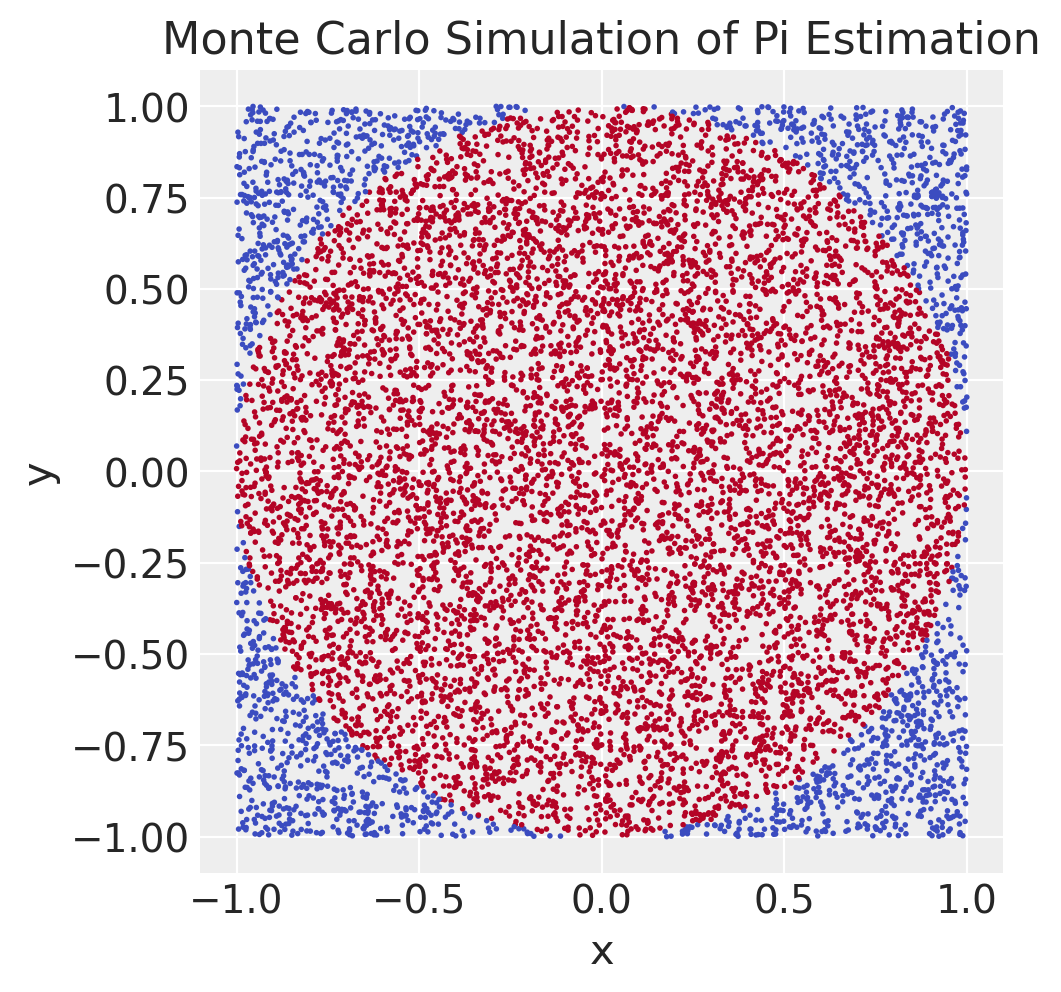

In [9]:
M = 10_000
model = CmdStanModel(stan_file='../../stan/monte-carlo-pi.stan')

sample = model.sample(
    chains=1, iter_warmup=1, iter_sampling=M,
    show_progress=False, show_console=False,
    seed=123
)

x_draws = sample.stan_variable('x')
y_draws = sample.stan_variable('y')
inside_draws = sample.stan_variable('inside')
pi_draws = sample.stan_variable('pi')

df = pd.DataFrame({'N': 1000, 'x': x_draws, 'y': y_draws, 'inside': inside_draws})

plt.figure(figsize=(5, 5))
plt.scatter(df['x'], df['y'], c=df['inside'], cmap='coolwarm', s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Monte Carlo Simulation of Pi Estimation')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Successivamente, calcoliamo la media campionaria dell'indicatore dentro-il-cerchio, che produce una stima della probabilità che un punto sia dentro il cerchio:

In [10]:
Pr_is_inside = np.mean(inside_draws)
pi_hat = np.mean(pi_draws)
print(f"Pr[Y is inside circle] = {Pr_is_inside:.3f};")
print(f"estimate for pi = {pi_hat:.3f}")

Pr[Y is inside circle] = 0.786;
estimate for pi = 3.144


Il valore esatto di $\pi$ fino a tre cifre decimali è $3.142$. Con il nostro metodo, ci avviciniamo a questo valore, ma non lo raggiungiamo esattamente, il che è tipico dei metodi Monte Carlo. Aumentando il numero di estrazioni, l'errore diminuisce. Teoricamente, con un numero sufficiente di estrazioni, possiamo ottenere qualsiasi precisione desiderata; tuttavia, in pratica, dobbiamo accontentarci di pochi decimali di accuratezza nelle nostre stime Monte Carlo. Questo di solito non è un problema, poiché l'incertezza statistica tende a dominare rispetto all'imprecisione numerica nella maggior parte delle applicazioni.

## Metodi Monte Carlo a Catena di Markov

Nelle sezioni precedenti, abbiamo visto come generare un campione eseguendo una serie di estrazioni indipendenti e calcolare la media dei risultati per ottenere stime delle aspettative.

Nei moderni modelli bayesiani, raramente è possibile generare estrazioni indipendenti dalle distribuzioni di interesse. Questo rende i semplici metodi Monte Carlo non applicabili. Solo in rari casi, con modelli molto semplici, è possibile ottenere estrazioni indipendenti, ma questi casi sono limitati (Diaconis e Ylvisaker 1979). Prima della rivoluzione dei metodi Monte Carlo a catena di Markov (MCMC) negli anni '90, l'inferenza bayesiana era per lo più limitata a questi modelli semplici.

L'introduzione dei metodi MCMC ha rivoluzionato l'inferenza bayesiana. Questi metodi permettono di generare campioni da distribuzioni complesse dove non è possibile ottenere estrazioni indipendenti. Tra questi, il metodo Hamiltonian Monte Carlo (HMC) è particolarmente efficiente e scalabile, grazie all'uso della differenziazione automatica. HMC è implementato in Stan e ha ampliato notevolmente la gamma di modelli che possono essere analizzati in tempi ragionevoli.

### Catene di Markov

Nei metodi Monte Carlo a catena di Markov, ogni estrazione dipende dall'estrazione precedente. Una sequenza di variabili casuali in cui ciascuna dipende solo dalla variabile precedente è chiamata catena di Markov. In altre parole, una catena di Markov è una sequenza di variabili casuali dove ogni variabile è condizionatamente indipendente dalle precedenti, dato il valore della variabile immediatamente precedente.

### Esempio di Catena di Markov

Consideriamo un esempio semplice con tre catene di Markov, tutte con una distribuzione stazionaria di $\theta = 0.5$. Questo significa che, col tempo, la distribuzione delle estrazioni converge a una distribuzione Bernoulli con parametro $\theta$ pari a 0.5. La media a lungo termine delle estrazioni si avvicinerà a 0.5, poiché questo è il valore atteso di una variabile Bernoulli con parametro $\theta$.

Ecco un programma Stan che implementa una catena di Markov:

```stan
data {
  int<lower=0> M;
  real<lower=0, upper=1> rho;  // probabilità di rimanere nello stesso stato
}
generated quantities {
  array[M] int<lower=0, upper=1> y;  // Catena di Markov
  y[1] = bernoulli_rng(0.5);
  for (m in 2:M) {
    y[m] = bernoulli_rng(y[m - 1] ? rho : 1 - rho);
  } 
}
```

In questo programma, `y[m]` viene assegnato utilizzando un'operazione ternaria. Se `y[m - 1]` è 1, `y[m]` è assegnato a `bernoulli_rng(rho)`, altrimenti è assegnato a `bernoulli_rng(1 - rho)`. Questo crea una catena di Markov dove la probabilità di rimanere nello stesso stato è `rho`.

In conclusione, i metodi Monte Carlo a catena di Markov, come l'Hamiltonian Monte Carlo, hanno ampliato notevolmente le capacità dell'inferenza bayesiana, permettendo di affrontare modelli complessi che non possono essere analizzati con semplici estrazioni indipendenti.

## Il Problema Inverso delle Nascite di Laplace

Quando si dispone di un modello che genera dati a partire dai parametri, il problema inverso consiste nell'inferire i valori dei parametri dai dati osservati. Questo tipo di problema richiede di ragionare a ritroso dalle osservazioni, attraverso il modello di misurazione e il modello diretto, per stimare parametri come, ad esempio, la probabilità di successo. La risoluzione dei problemi inversi è uno degli ambiti in cui le statistiche bayesiane eccellono.

### Storia e Applicazione

Un decennio dopo la pubblicazione della regola di Bayes, Laplace utilizzò la funzione beta di Eulero per derivare formalmente la distribuzione a posteriori. In questa sezione, analizzeremo il problema di Laplace utilizzando Stan.

Laplace raccolse dati sul sesso dei bambini nati vivi a Parigi tra il 1745 e il 1770:

| Sesso   | Nascite vive |
|---------|--------------|
| Femmina | 105.287      |
| Maschio | 110.312      |

Laplace si chiese se, sulla base di questi dati, la probabilità di nascita dei maschi fosse superiore a quella delle femmine.

### Modello di Laplace

Laplace adottò la seguente distribuzione campionaria per modellare il numero di maschi nati su un totale di $N$ nascite:

$$
y \sim \text{binomiale}(N, \theta),
$$

dove $N$ è il numero totale di nascite, $\theta$ è la probabilità di nascita di un maschio e $y$ è il numero di nascite maschili.

### Distribuzione a Priori

Laplace utilizzò la seguente distribuzione a priori per $\theta$:

$$
\theta \sim \text{beta}(1, 1),
$$

dove la distribuzione $\text{beta}(1, 1)$ è uniforme sull'intervallo $\theta \in (0, 1)$ poiché la densità è proporzionale a una costante:

$$
\text{beta}(\theta \mid 1, 1) \propto \theta^{1 - 1} \cdot (1 - \theta)^{1 - 1} = 1.
$$

### Distribuzione a Posteriori

Il modello di Laplace è abbastanza semplice da permettere una soluzione analitica della distribuzione a posteriori:

$$
\begin{aligned}
    p(\theta \mid y, N) &\propto p(y \mid N, \theta) \cdot p(\theta) \\
    &= \text{binomiale}(y \mid N, \theta) \cdot \text{beta}(\theta \mid 1, 1) \\
    &\propto \theta^y \cdot (1 - \theta)^{N - y} \cdot \theta^{1 - 1} \cdot (1 - \theta)^{1 - 1} \\
    &= \theta^{y} \cdot (1 - \theta)^{N - y} \\
    &\propto \text{beta}(\theta \mid y + 1, N - y + 1).
\end{aligned}
$$

Quindi, possiamo concludere che:

$$
p(\theta \mid y, N) = \text{beta}(\theta \mid y + 1, N - y + 1).
$$

### Implementazione in Stan

A differenza del primo modello Stan che abbiamo visto, che generava solo dati, il seguente programma Stan richiede che vengano forniti dati, specificamente il numero di nascite maschili ($y$) e il numero totale di nascite ($N$). Il modello ci permetterà di stimare la probabilità di nascita di un maschio ($\theta$) e la probabilità che nascano più maschi che femmine ($\theta > 0.5$).

Ecco come possiamo specificare il modello Stan:

In [12]:
stan_file = os.path.join(
    project_directory, 'stan', 'sex-ratio.stan')

with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower = 0> N;
  int<lower = 0, upper = N> y;
  int<lower = 0> alpha_prior;
  int<lower = 0> beta_prior;
}
parameters {
  real<lower=0, upper=1> theta;
}
model {
  theta ~ beta(alpha_prior, beta_prior);
  y ~ binomial(N, theta);
}
generated quantities {
  int<lower=0, upper=1> boys_gt_girls = theta > 0.5;
}



In questo programma Stan, vediamo che sia il numero totale di nascite ($N$) sia il numero di nascite maschili ($y$) sono forniti come dati. Poi ci sono due blocchi aggiuntivi: un _blocco dei parametri_, usato per dichiarare valori sconosciuti (qui, solo il tasso di nascite maschili $\theta$), e un _blocco del modello_, dove specifichiamo la distribuzione a priori e la verosimiglianza. La distribuzione a posteriori viene calcolata da Stan combinando queste due componenti. Inoltre, c'è un **blocco delle quantità generate** dove viene calcolata una variabile booleana che indica se la probabilità di nascita dei maschi $\theta$ è maggiore di 0.5.

Il modello di Laplace e la sua implementazione in Stan ci permettono di affrontare il problema inverso delle nascite, inferendo la probabilità di nascita di un maschio dai dati osservati. Utilizzando le tecniche bayesiane, possiamo stimare non solo la probabilità di nascita di un maschio, ma anche la probabilità che nascano più maschi che femmine.

## Campionare dalla Distribuzione a Posteriori

Quando eseguiamo un programma Stan, esso genera una serie di campioni casuali che approssimano la distribuzione a posteriori. Con il proseguire delle estrazioni, questi campioni tendono a diventare sempre più simili a veri campioni della distribuzione a posteriori, fino a diventare numericamente indistinguibili da essa.

Stan utilizza un algoritmo Markov Chain Monte Carlo (MCMC), che può introdurre autocorrelazione nei campioni della distribuzione a posteriori. In altre parole, i campioni non sono indipendenti tra loro, ma ogni campione è correlato (o anti-correlato) con il campione precedente.

L'autocorrelazione non introduce bias nelle stime Monte Carlo, ma i campioni positivamente autocorrelati, che si osservano nei modelli più complessi, aumentano la varianza delle stime rispetto ai campioni indipendenti. Questo incremento della varianza aumenta l'errore quadratico medio atteso, che è una combinazione di errore dovuto al bias (qui nullo) e alla varianza. Al contrario, nei modelli molto semplici, l'autocorrelazione negativa riduce la varianza rispetto ai campioni indipendenti, riducendo quindi l'errore quadratico medio atteso.

Per affrontare problemi ad alta dimensionalità, Duane et al. (1987) hanno introdotto l'algoritmo Hamiltonian Monte Carlo (HMC) che migliora l'efficienza del campionamento. Per Stan, Hoffman e Gelman (2014) hanno sviluppato una versione adattiva dell'HMC chiamata No-U-Turn Sampler (NUTS), successivamente migliorata da Betancourt (2017a). NUTS può essere estremamente efficiente, generando campioni anti-correlati che possono portare a stime Monte Carlo più precise rispetto ai campioni indipendenti.

### Compilazione del Codice Stan

Per utilizzare Stan, dobbiamo compilare il codice del modello. Questo crea un file eseguibile che, nel nostro caso, abbiamo chiamato `model`.

In [13]:
model = CmdStanModel(stan_file=stan_file)

I dati devono essere contenuti in un dizionario. 

In [14]:
boys = 110312
girls = 105287

data = {
    'N': boys + girls, 
    'y': boys,
    "alpha_prior" : 1,
    "beta_prior" : 1
    }

print(data)

{'N': 215599, 'y': 110312, 'alpha_prior': 1, 'beta_prior': 1}


Possiamo ora eseguire il campionamento MCMC con la seguente chiamata.

In [15]:
sample = model.sample(
    data=data,
    iter_warmup = 1000,
    iter_sampling = 10_000,
    seed = 123,
    show_progress = False, 
    show_console = False
)

Il metodo `$sample()` viene applicato al file eseguibile del modello Stan che abbiamo compilato e nominato `model`.

Avendo assunto una distribuzione a priori per il parametro $\theta$, l'algoritmo procede in maniera ciclica, aggiornando la distribuzione a priori di $\theta$ condizionandola ai valori già generati. Dopo un certo numero di iterazioni, l'algoritmo raggiunge la convergenza, e i valori estratti possono essere considerati campioni dalla distribuzione a posteriori di $\theta$.

All'inizio del campionamento, la distribuzione dei campioni può essere significativamente diversa dalla distribuzione stazionaria. Questo periodo iniziale è chiamato "burn-in". Durante il burn-in, i campioni possono non rappresentare accuratamente la distribuzione a posteriori e sono tipicamente scartati. Man mano che il numero di iterazioni aumenta, la distribuzione dei campioni si avvicina sempre più alla distribuzione target.

Dopo aver eseguito il modello in Stan, otteniamo una serie di campioni $\theta^{(m)}$ dalla distribuzione a posteriori $p(\theta \mid N, y)$. Ogni campione rappresenta un possibile valore di $\theta$ compatibile con i dati osservati $y$. Procediamo quindi a estrarre i campioni a posteriori per le variabili `theta` e `boys_gt_girls`.

In [16]:
theta_draws = sample.stan_variable('theta')
boys_gt_girls_draws = sample.stan_variable('boys_gt_girls')

Tracciando un istogramma di questi campioni, possiamo visualizzare dove i valori di $\theta$ sono più probabili e comprendere meglio la forma della distribuzione a posteriori. L'istogramma ci fornisce diverse informazioni:

- **Valore più probabile di $\theta$**: Questo è il valore intorno al quale i campioni sono più concentrati, noto come la moda della distribuzione.
- **Distribuzione dei possibili valori di $\theta$**: Questo ci dà un'idea dell'incertezza nella stima di $\theta$.

Se l'istogramma è stretto e concentrato attorno a un valore specifico, significa che c'è poca incertezza nella stima di $\theta$. In altre parole, possiamo essere abbastanza sicuri che il valore vero di $\theta$ sia vicino a questo valore.

Se l'istogramma è largo e distribuito, significa che c'è maggiore incertezza nella stima di $\theta$. Questo indica che i dati osservati non forniscono una stima precisa e che il valore di $\theta$ potrebbe variare notevolmente.

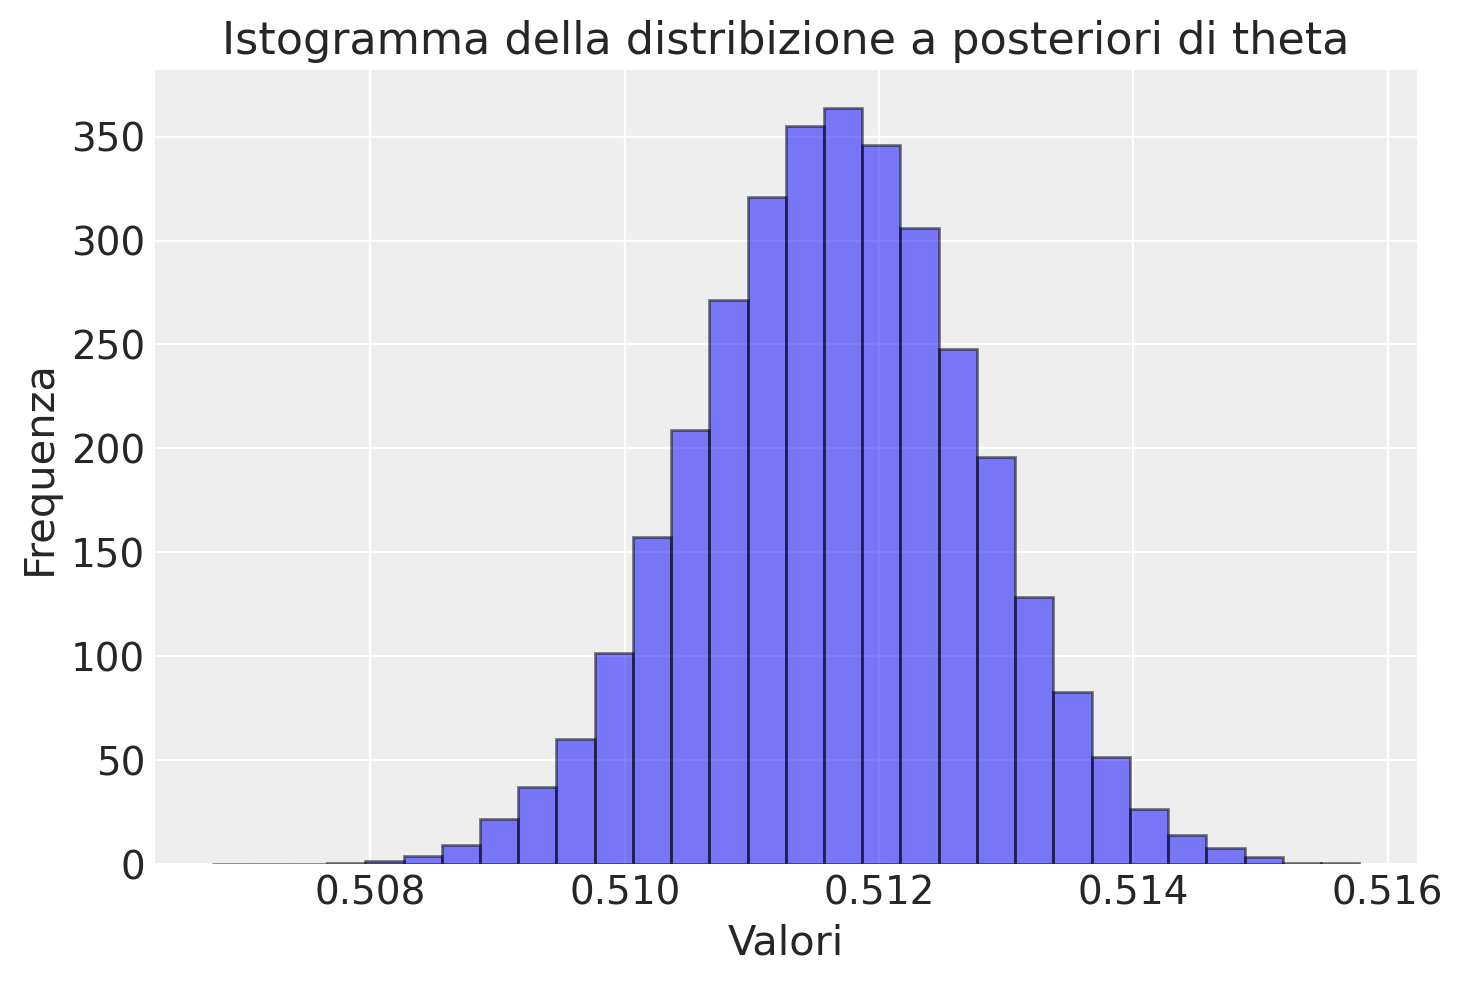

In [17]:
plt.hist(theta_draws, bins=30, alpha=0.5, color='b', edgecolor='black', density=True)

# Aggiunta di titolo e etichette agli assi
plt.title('Istogramma della distribizione a posteriori di theta')
plt.xlabel('Valori')
plt.ylabel('Frequenza')

plt.show()

## Stime Puntuali Bayesiane

In termini bayesiani, una _stima puntuale_ per un parametro $\Theta$ condizionato sui dati osservati $Y = y$ è un singolo valore $\hat{\theta} \in \mathbb{R}^D$ che riassume la distribuzione a posteriori $p(\theta \mid y)$. La notazione $\hat{\theta}$ è convenzionale nella statistica per indicare una stima di un parametro $\theta$. In questa sezione definiamo tre stimatori e discutiamo come i due stimatori bayesiani minimizzino una _funzione di perdita_ tra il valore vero e la stima. Torneremo alla funzione di perdita e alle proprietà degli stimatori dopo averli definiti.

### Stimatore della Media Posteriori

La stima puntuale bayesiana più comune per un parametro è la media posteriori,

$$
\begin{align}
\widehat{\theta}
&= \mathbb{E}[\Theta \mid Y = y] \\
&= \int_{\Theta} \theta \cdot p(\theta \mid y) \, \textrm{d}\theta \\
&= \lim_{M \rightarrow \infty} \, \frac{1}{M} \sum_{m=1}^M \theta^{(m)} \\
&\approx \frac{1}{M} \sum_{m=1}^M \theta^{(m)},
\end{align}
$$

dove nelle ultime due righe, ogni estrazione è distribuita approssimativamente secondo la distribuzione a posteriori,

$$
\theta^{(m)} \sim p(\theta \mid y).
$$

Abbiamo introdotto la notazione di _aspettativa condizionale_ nella prima riga di questa definizione. Le aspettative sono semplicemente medie ponderate, con i pesi dati da una densità di probabilità. L'inferenza bayesiana coinvolge aspettative sulla distribuzione a posteriori, la cui notazione concisa è quella dell'*aspettativa condizionale*,

$$
\mathbb{E}\!
\left[ f(\Theta) \mid Y = y \right]
= \int_{\mathbb{R^N}} f(\theta) \cdot p_{\Theta \mid Y}(\theta \mid y) \, \textrm{d}\theta,
$$

dove $\Theta$ e $Y$ sono variabili casuali, mentre $\theta$ e $y$ sono variabili vincolate ordinarie.

Per il modello di Laplace, la stima per il tasso di nascite maschili $\theta$ condizionata sui dati di nascita $y$ è calcolata come la media campionaria delle estrazioni per `theta`.

In [18]:
theta_hat = np.mean(theta_draws)
print(f"estimated theta = {theta_hat:.3f}")

estimated theta = 0.512


### Stimatore della Mediana Posteriori, Quantili e Intervalli

Un'alternativa popolare alla stima puntuale bayesiana è la _mediana posteriori_, $\theta^+$. La mediana è il valore tale che, per ogni dimensione $d \in 1{:}D$,

$$
\Pr[\Theta_d \leq \theta^+_d] = \frac{1}{2}.
$$

In altre parole, la mediana è il valore che divide la distribuzione a posteriori in due parti uguali: il 50% dei campioni è al di sotto della mediana e il 50% è al di sopra. La mediana posteriori può essere calcolata prendendo la mediana dei campioni dalla distribuzione a posteriori.

Ecco come calcolare la mediana posteriori utilizzando Python:

In [19]:
theta_plus = np.median(theta_draws)
print(f"estimated (median) theta = {theta_plus:.3f}")

estimated (median) theta = 0.512


Poiché la distribuzione a posteriori per i dati di Laplace è quasi simmetrica, la media posteriori e la mediana posteriori sono molto simili.

### Quantili e Intervalli di Credibilità

Oltre alla mediana, possiamo anche calcolare i quantili e gli intervalli di credibilità per fornire ulteriori informazioni sulla distribuzione a posteriori. I quantili sono valori che dividono la distribuzione in intervalli con una probabilità specificata. Gli intervalli di credibilità indicano l'intervallo entro il quale cade una certa percentuale della distribuzione a posteriori.

#### Quantili

Ad esempio, se vogliamo calcolare il quantile al 95% della distribuzione a posteriori, possiamo semplicemente prendere il valore che si trova al 95° percentile nella sequenza ordinata dei campioni. Di seguito sono riportati i quantili al 5% e al 95% della distribuzione a posteriori di Laplace, calcolati utilizzando i quantili empirici.

In [20]:
quantile_05 = np.quantile(theta_draws, 0.05)
quantile_95 = np.quantile(theta_draws, 0.95)
print(f"""0.05 quantile = {quantile_05:.3f};
0.95 quantile = {quantile_95:.3f}""")

0.05 quantile = 0.510;
0.95 quantile = 0.513


#### Intervalli Posteriori

Insieme, il quantile al 5% e al 95% ci forniscono i limiti del nostro _intervallo di probabilità centrale_ al 90%. Questo intervallo è definito come l'intervallo che contiene il 90% della massa di probabilità a posteriori, con il 5% della massa rimanente al di sotto dell'intervallo e il 5% al di sopra.

### Errore di Stima e Bias

L'_errore_ di una stima è la differenza tra la stima stessa e il valore vero del parametro,

$$
\textrm{err} = \hat{\theta} - \theta.
$$

La nostra stima $\hat{\theta}$ è implicitamente una funzione dei dati $y$, quindi anche l'errore dipende dai dati. Possiamo rendere esplicita questa dipendenza scrivendo

$$
\text{err}(y) = \hat{\theta}(y) - \theta.
$$

Il _bias_ di uno stimatore è definito come l'errore atteso, cioè la media dell'errore rispetto alla distribuzione dei dati per la variabile casuale $Y$,

$$
\begin{align}
\text{bias}
&= \mathbb{E}[\text{err}(Y)] \\
&= \mathbb{E}[\hat{\theta}(Y) - \theta] \\
&= \int_Y (\hat{\theta}(y) - \theta) \, \text{d}y.
\end{align}
$$

In altre parole, il bias misura quanto, in media, la stima $\hat{\theta}$ si discosta dal valore vero $\theta$ considerando tutte le possibili realizzazioni dei dati $Y$. Un bias nullo indica che lo stimatore è corretto in media, cioè non tende a sovrastimare o sottostimare il valore vero del parametro.

### Stimatore della Moda Posteriori

Uno stimatore popolare, sebbene non strettamente bayesiano, è la moda a posteriori, che rappresenta il valore del parametro $\theta$ per cui la densità a posteriori è massima. Formalmente, è definita come:

$$ 
\theta^* = \text{arg max}_\theta \ p(\theta \mid y). 
$$

La stima $\theta^*$ è spesso chiamata stima MAP (Maximum A Posteriori). La moda a posteriori non è considerata un vero stimatore bayesiano perché non tiene conto dell'incertezza nella stessa misura in cui lo fanno altri metodi bayesiani. In altre parole, non minimizza una funzione di perdita basata sui valori veri dei parametri, ma cerca semplicemente il valore più probabile dato i dati osservati.

### Caratteristiche della Moda Posteriori

- **Non considera l'incertezza**: La stima MAP si focalizza solo sul valore più probabile della distribuzione a posteriori, senza tenere conto della variabilità dei dati.
- **Massimo della densità a posteriori**: La moda a posteriori rappresenta il punto in cui la densità a posteriori raggiunge il suo massimo.
- **Possibili limitazioni**: La stima MAP potrebbe non esistere in alcuni casi, come nei modelli in cui la densità cresce senza limiti. Questo può accadere, ad esempio, nei modelli bayesiani gerarchici o in distribuzioni semplici come la distribuzione esponenziale con parametro 1 ($\textrm{esponenziale}(1)$).

### Funzioni di Perdita e Proprietà degli Stimatori

La media a posteriori è uno stimatore bayesiano popolare per due ragioni principali. Primo, è uno stimatore non distorto, il che significa che ha un bias nullo. Secondo, ha l'errore quadratico medio atteso minimo tra tutti gli stimatori non distorti. L'errore quadratico di una stima è definito come:

$$ 
\text{err}^2(y) = \left(\hat{\theta}(y) - \theta\right)^2. 
$$

Questa è una funzione di perdita, che misura la differenza tra una stima $\hat{\theta}$ e il valore vero $\theta$. Tuttavia, la media a posteriori potrebbe non esistere se la distribuzione a posteriori ha code molto ampie, come accade nella distribuzione di Cauchy standard.

### Proprietà della Mediana Posteriori

La mediana a posteriori $\theta^+$ ha tre proprietà interessanti:

1. **Sempre ben definita**: La mediana a posteriori è sempre ben definita, anche per densità con poli o code molto ampie.
2. **Minimizzazione dell'errore assoluto atteso**: La mediana minimizza l'errore assoluto atteso, il che la rende robusta.
3. **Robustezza ai valori anomali**: La mediana è meno sensibile ai valori anomali rispetto alla media, perché minimizza l'errore assoluto anziché l'errore quadrato.

### Concentrazione sulle Medie a Posteriori

In questa introduzione a Stan, ci concentreremo principalmente sulle medie a posteriori. La media a posteriori non solo fornisce una stima non distorta, ma minimizza anche l'errore quadratico medio atteso, rendendola uno strumento potente per l'inferenza bayesiana. Tuttavia, è importante essere consapevoli delle sue limitazioni, specialmente in presenza di distribuzioni a posteriori con code molto ampie.

### Errore (Markov Chain) Monte Carlo e Dimensione del Campione Effettivo

Quando utilizziamo un campionatore di catene di Markov per stimare parametri, otteniamo una sequenza di campioni casuali. Questa sequenza è essa stessa una variabile casuale, perché è composta da molte variabili casuali. A causa di questa natura casuale, ogni esecuzione del campionatore può produrre risultati leggermente diversi, introducendo quello che è noto come errore Monte Carlo.

L'errore Monte Carlo è l'errore introdotto dal fatto che utilizziamo solo un numero finito di campioni ($ M $) per stimare i parametri. Questo tipo di errore si verifica perché, con un numero limitato di campioni, non possiamo catturare perfettamente l'intera distribuzione a posteriori.

#### Errore Standard di Monte Carlo (MCMC)

Stan riporta l'errore standard di Monte Carlo (MCMC) insieme alle stime della media. L'errore standard MCMC per un parametro scalare $ \theta_d $ è definito come:

$$
\text{mcmc-se} = \frac{\textrm{sd}[\Theta_d \mid Y = y]}{\sqrt{N^{\text{eff}}}},
$$

dove:
- $\text{sd}[\Theta_d \mid Y = y]$ è la deviazione standard del parametro $ \theta_d $ nella distribuzione a posteriori.
- $N^{\text{eff}}$ è la dimensione del campione effettivo, che riflette il numero di campioni indipendenti equivalenti ottenuti dal campionatore.

#### Dimensione del Campione Effettivo

Nel classico teorema del limite centrale, la dimensione del campione (numero di estrazioni indipendenti) appare al posto di $N^{\text{eff}}$. Tuttavia, nel contesto delle catene di Markov, i campioni successivi sono correlati tra loro. La dimensione del campione effettivo ($N^{\text{eff}}$) tiene conto di questa correlazione e rappresenta il numero di estrazioni indipendenti che porterebbero allo stesso errore delle nostre estrazioni correlate.

La dimensione del campione effettivo per un campione di dimensione $ M $ è definita come:

$$
N^{\text{eff}} = \frac{M}{\text{IAT}},
$$

dove $\text{IAT}$ è il tempo di autocorrelazione integrata. Sebbene non sia definito formalmente qui, può essere considerato come l'intervallo tra estrazioni effettivamente indipendenti nella nostra catena di Markov. Se l'autocorrelazione è bassa, $\text{IAT}$ sarà vicino a 1; se l'autocorrelazione è alta, $\text{IAT}$ sarà molto più alto. 

In sintesi, $N^{\text{eff}}$ rappresenta il numero di estrazioni indipendenti che porterebbero allo stesso errore delle estrazioni correlate della nostra catena di Markov.

In conclusione, l'errore standard di Monte Carlo (MCMC) fornisce una misura di quanto varierebbero le nostre stime se ripetessimo il processo di campionamento più volte. È un indicatore dell'affidabilità delle nostre stime, tenendo conto della casualità introdotta dall'utilizzo di un numero finito di campioni. Conoscere questo errore ci aiuta a valutare la precisione delle nostre stime e a comprendere meglio l'incertezza associata ai risultati ottenuti tramite il campionamento di catene di Markov.

## Stima delle Probabilità di Evento

Laplace non cercava semplicemente un valore specifico per $\theta$. Voleva sapere qual era la probabilità che $\theta$ fosse maggiore di $\frac{1}{2}$ dopo aver osservato $y$ nascite maschili su un totale di $N$ nascite. In termini di teoria della probabilità, voleva stimare la probabilità di un evento.

Un sottoinsieme di parametri è noto come _evento_. Possiamo convertire le condizioni sui parametri in eventi. Ad esempio, la condizione $\theta > \frac{1}{2}$ può essere espressa come l'evento:

$$ A = \left\{ \theta \in \Theta : \theta > \frac{1}{2} \right\}. $$

Data una misura di probabilità, la probabilità dell'evento $A$, ossia che il tasso di nascite maschili sia superiore a quello delle nascite femminili, sarà ben definita. Poiché possiamo convertire le condizioni in eventi, possiamo trattarle come tali. Questo ci permette di scrivere $\Pr\!\left[\Theta > \frac{1}{2} \, \big| \, N, y\right]$ per indicare la probabilità dell'evento $\Theta > \frac{1}{2}$.

### Probabilità di Evento tramite Indicatori

La _funzione indicatrice_ $\textrm{I}$ assegna il valore 1 alle proposizioni vere e 0 a quelle false. Ad esempio, $\textrm{I}(\theta > \frac{1}{2}) = 1$ se la proposizione $\theta > \frac{1}{2}$ è vera, cioè quando $\theta$ è maggiore di un mezzo.

Le _probabilità di evento_ sono definite come aspettative condizionali posteriori delle funzioni indicatrici per eventi:

$$
\begin{align}
\Pr[\Theta > 0.5 \mid N, y]
&= \mathbb{E}\!\left[\textrm{I}[\Theta > 0.5] \mid N, y\right] \\
&= \int_{\Theta} \textrm{I}(\theta > 0.5) \cdot p(\theta \mid N, y) \, \textrm{d}\theta \\
&\approx \frac{1}{M} \sum_{m=1}^M \textrm{I}(\theta^{(m)} > 0.5),
\end{align}
$$

dove $\theta^{(m)}$ rappresenta i campioni dalla distribuzione a posteriori $p(\theta \mid N, y)$ per $m = 1, 2, \ldots, M$.

### Eventi come Indicatori in Stan

In Stan, possiamo codificare direttamente il valore della funzione indicatrice e assegnarlo a una variabile nel blocco delle quantità generate.

```stan
generated quantities {
  int<lower=0, upper=1> boys_gt_girls = theta > 0.5;
}
```

Le espressioni condizionali come `theta > 0.5` assumono il valore 1 se sono vere e 0 se sono false. In notazione matematica, scriveremmo $\textrm{I}(\theta > 0.5)$, che assume valore 1 se $\theta > 0.5$ e 0 altrimenti. In Stan, come in C++, trattiamo `>` come un operatore binario che restituisce 0 o 1, quindi scriviamo semplicemente `theta > 0.5`.

### La Risposta alla Domanda di Laplace

La media a posteriori della variabile `boys_gt_girls` è quindi la nostra stima per $\Pr[\theta > 0.5 \mid N, y]$. È essenzialmente 1. Stampando a 15 cifre decimali, vediamo

In [21]:
Pr_boy_gt_girl = np.mean(boys_gt_girls_draws)
print(f"estimated Pr[boy more likely] = {Pr_boy_gt_girl:.15f}")

estimated Pr[boy more likely] = 1.000000000000000


Come possiamo vedere di seguito, tutti i nostri campioni per $\theta$ sono maggiori di $\frac{1}{2}$, ovvero `boys_gt_girls_draws` è sempre uguale a 1:

In [22]:
np.unique(boys_gt_girls_draws)

array([1.])

Il valore 1 restituito come stima solleva l'importante problema della precisione numerica. Laplace calcolò il risultato analiticamente, che è

$$
\Pr\!\left[\Theta > \frac{1}{2} \ \bigg| \ N, y\right] \approx 1 - 10^{-27}.
$$

Quindi avremmo bisogno di un numero astronomico di campioni a posteriori prima di generare un valore di $\theta$ inferiore a $\frac{1}{2}$. Come detto, la risposta di 1.0 è molto vicina alla risposta vera e ben entro il nostro errore Monte Carlo atteso. 

### Statistiche di riepilogo MCMC da Stan

Con Stan, possiamo ottenere un riepilogo completo della variabile $\theta$ nella distribuzione a posteriori. Per fare ciò, basta chiamare la funzione `.summary()` sul campione. Questo riepilogo include tutte le statistiche rilevanti.

In [23]:
sample.summary(sig_figs = 3)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-149000.000,0.004770,6.720000e-01,-149000.00,-149000.000,-149000.000,19800.0,60700.0,1.0
theta,0.512,0.000009,1.090000e-03,0.51,0.512,0.513,13700.0,41900.0,1.0
boys_gt_girls,1.000,NaN,9.380000e-14,1.00,1.000,1.000,NaN,NaN,NaN


L'istruzione `print(sample.diagnose())` in Stan viene utilizzata per eseguire una diagnosi completa del campionamento MCMC. Questa funzione fornisce una serie di statistiche diagnostiche che aiutano a valutare la qualità e la convergenza del campionamento. 

Questi sono alcuni degli aspetti che possono essere diagnosticati:

1. **Convergenza**: La diagnosi verifica se le catene di Markov sono convergenti, ad esempio controllando il valore di $\hat{R}$. Un valore di $\hat{R}$ vicino a 1 indica che le catene sono ben mescolate e convergenti.

2. **Autocorrelazione**: Fornisce informazioni sull'autocorrelazione delle catene, che può influire sull'efficienza del campionamento. Bassa autocorrelazione è desiderabile per ottenere campioni indipendenti.

3. **Efficienza del campionamento**: Viene calcolata la dimensione del campione effettivo ($N_{\text{eff}}$), che indica quanti campioni indipendenti equivarrebbero ai campioni correlati ottenuti.

4. **Varianza e Deviazione Standard**: Viene riportata la varianza e la deviazione standard dei campioni, aiutando a comprendere la distribuzione a posteriori del parametro.

In [24]:
print(sample.diagnose())

Processing csv files: /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmphjrqbjja/sex-ratiov0k3fisb/sex-ratio-20240722114626_1.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmphjrqbjja/sex-ratiov0k3fisb/sex-ratio-20240722114626_2.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmphjrqbjja/sex-ratiov0k3fisb/sex-ratio-20240722114626_3.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmphjrqbjja/sex-ratiov0k3fisb/sex-ratio-20240722114626_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



Un grafico con le tracce si ottiene nel modo seguente:

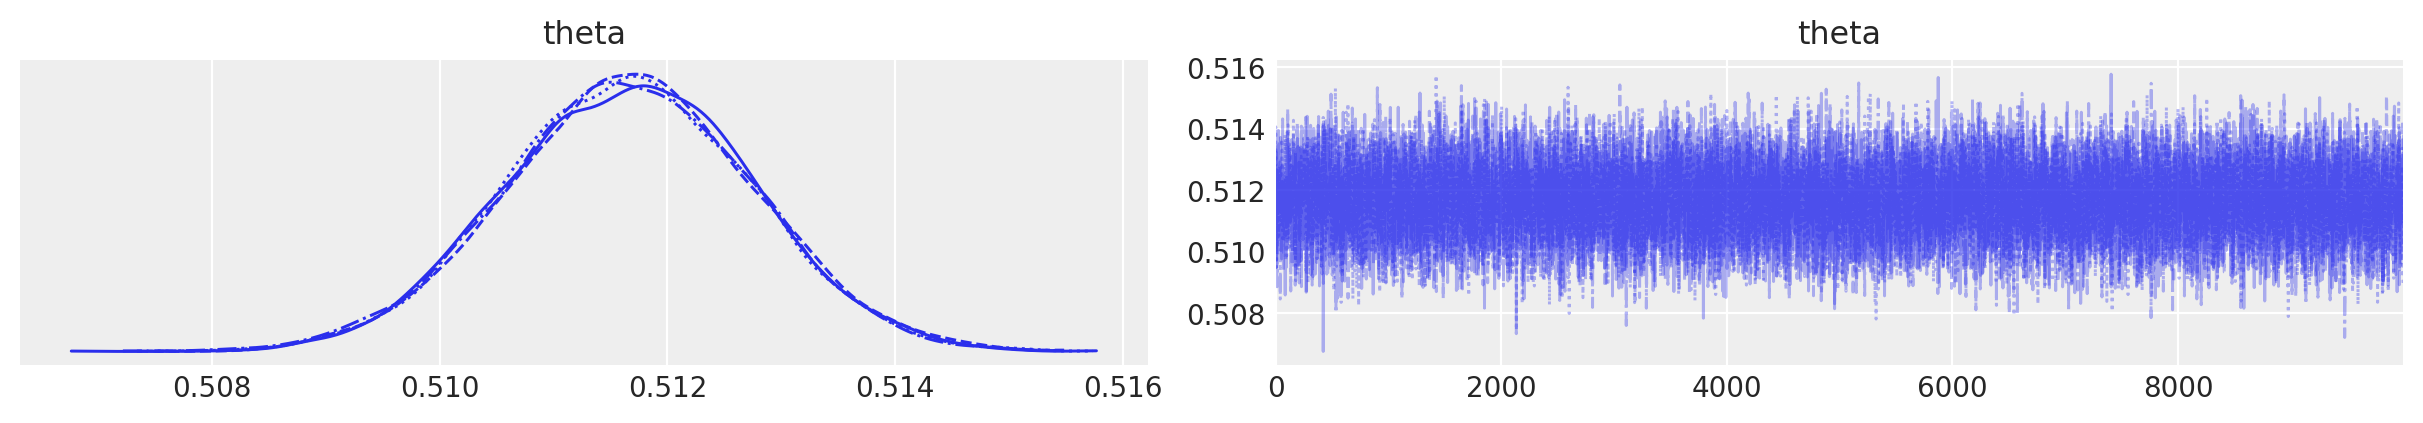

In [25]:
_ = az.plot_trace(sample, var_names=("theta"), combined=False)

# Riscaldamento e monitoraggio della convergenza

Quando si eseguono catene di Markov, è importante assicurarsi che i campioni siano approssimativamente estratti dalla distribuzione a posteriori. Un modo standard per monitorare la convergenza è avviare più catene di Markov con inizializzazioni diverse (idealmente scelte da una distribuzione iniziale diffusa) e misurare se stanno producendo campioni dalla stessa distribuzione.

## Riscaldamento

Durante le fasi iniziali di riscaldamento, Stan cerca di trovare la regione di alta probabilità da cui campionare, adattare una buona dimensione del passo e stimare la varianza a posteriori. La varianza stimata viene utilizzata per migliorare l'efficienza del campionatore, un processo chiamato "precondizionamento". Precondizionare significa ridimensionare i parametri per rendere il campionamento più efficiente.

Stan può anche stimare una matrice di covarianza completa, che rappresenta le relazioni tra tutti i parametri. Utilizzando questa matrice, Stan può effettuare rotazioni e ridimensionamenti dei parametri per campionare in modo più efficace. In questo contesto, "rotazione e scalatura" si riferiscono alla trasformazione dei parametri in una nuova base (rotazione) e alla regolazione delle loro scale (scalatura) per facilitare il campionamento, rendendolo più rapido e affidabile. Per ulteriori dettagli su questi processi, si può fare riferimento a Neal (2011).

Il riscaldamento converge quando la dimensione del passo e le stime della covarianza a posteriori diventano stabili. Con più catene, è possibile verificare che tutte convergano verso una dimensione del passo e una stima della covarianza simili. A meno che non ci siano problemi, generalmente non misuriamo la convergenza dell'adattamento, ma piuttosto se otteniamo campioni a posteriori ragionevoli dopo il riscaldamento.

Durante la fase di riscaldamento, Stan non produce una catena di Markov coerente perché utilizza la memoria per adattarsi alle condizioni del modello. Questo adattamento serve a trovare i migliori parametri di campionamento. Tuttavia, una volta terminato il riscaldamento e iniziata la fase di campionamento, Stan inizia a produrre una vera e propria catena di Markov.

Le nostre analisi a posteriori si baseranno esclusivamente sui campioni generati durante questa fase di campionamento, non sui campioni raccolti durante il riscaldamento. È comunque possibile salvare ed esaminare i campioni del riscaldamento per comprendere meglio come il processo di adattamento è avvenuto e se ci sono stati problemi.

## Riduzione potenziale della scala e $\widehat{R}$

Stan utilizza la statistica di *riduzione potenziale della scala* $\widehat{R}$ (pronunciata "R hat"). Dato un insieme di catene di Markov, Stan divide ciascuna di esse a metà per assicurarsi che la prima metà e la seconda metà della catena concordino, quindi calcola le varianze all'interno di ciascuna catena e tra tutte le catene e le confronta. La statistica $\widehat{R}$ converge a 1 quando le catene di Markov convergono alla stessa distribuzione.

## Quante catene per quanto tempo? 

Una semplice regola empirica consiste nell'eseguire quattro catene finché $\widehat{R} \leq 1.01$ e la dimensione campionaria effettiva (ESS) è superiore a 100. La raccomandazione di avere una dimensione campionaria effettiva di "soli" 100 è dovuta al fatto che questo valore implica un errore standard pari a $\frac{1}{10}$ della deviazione standard. Poiché la deviazione standard a posteriori rappresenta l'incertezza residua, calcolare le medie con una precisione maggiore è raramente utile.

Il modo più semplice per ottenere $\widehat{R} \leq 1.01$ e $N_{\text{eff}} > 100$ è iniziare con 100 iterazioni di riscaldamento e 100 iterazioni di campionamento. Se i valori di $\widehat{R}$ sono troppo alti o se la dimensione campionaria effettiva è troppo bassa, raddoppiare il numero di iterazioni di riscaldamento e di campionamento e riprovare. Eseguire più iterazioni di riscaldamento è importante perché il campionamento non sarà efficiente se il riscaldamento non è convergente. Utilizzare lo stesso numero di iterazioni di riscaldamento e di campionamento può comportare un costo massimo doppio rispetto alle impostazioni ottimali, che non sono note in anticipo.

Anche se si utilizzano più di quattro catene, è necessario assicurarsi che la dimensione campionaria effettiva sia almeno 25 per catena. Non è tanto per l'inferenza, quanto per garantire la fiducia nello stimatore della dimensione campionaria effettiva, che non è affidabile se è molto inferiore. Un modo per verificare l'adeguatezza dello stimatore ESS è raddoppiare il numero di campioni e assicurarsi che anche l'ESS raddoppi. Se ciò non accade, significa che la prima stima dell'ESS non è affidabile.

## Esecuzione delle catene contemporaneamente

È possibile impostare il numero di catene da eseguire utilizzando l'argomento `chains` del metodo `sample()`. Inoltre, è possibile controllare quante catene possono essere eseguite contemporaneamente con l'argomento `parallel_cores` (che per default è impostato su 1, ovvero esecuzione sequenziale).

Se il numero massimo di catene parallele è impostato troppo basso, le risorse della CPU potrebbero non essere sfruttate appieno. Al contrario, se è impostato troppo alto, la CPU o la memoria potrebbero diventare il collo di bottiglia, rallentando le prestazioni complessive rispetto all'esecuzione con un numero inferiore di catene parallele.

In progetti personali sul nostro hardware, l'obiettivo è solitamente ottenere la massima dimensione campionaria effettiva nel minor tempo possibile. Tuttavia, a volte è necessario lasciare abbastanza potenza di elaborazione per continuare a lavorare su altre attività come documenti, email, ecc.

### Matrici, Vettori o Array in Stan

Stan offre vari tipi di dati per gestire operazioni di algebra lineare e per definire strutture di dati più generali come gli array. Capire le differenze tra questi tipi è fondamentale per sapere cosa possiamo fare con essi e per ottimizzare la velocità di esecuzione del nostro modello.

1. **Tipi di base per l'algebra lineare**:
   - **`vector`**: un vettore colonna di dimensione N.
   - **`row_vector`**: un vettore riga di dimensione N.
   - **`matrix`**: una matrice di dimensioni N1 × N2.

2. **Array**:
   - Gli array possono essere creati con qualsiasi tipo di elemento e possono avere più dimensioni. Ad esempio:
     - `array[N] real a;` definisce un array unidimensionale di numeri reali.
     - `array[N1, N2] real m;` definisce un array bidimensionale di numeri reali.

3. **Intercambiabilità e limitazioni**:
   - Anche se possiamo usare sia `vector` che `array` per contenitori unidimensionali, l'algebra matriciale (come la moltiplicazione) è definita solo per vettori e matrici, non per array.
   - Alcune funzioni, come `normal_lpdf`, accettano sia vettori che array.

4. **Esempi pratici**:
   - Quando definiamo una media (`mu`) come somma di un parametro (`alpha`) e il prodotto di un vettore di carichi (`c_load`) con un coefficiente (`beta`), dobbiamo usare i vettori:
     ```stan
     vector[N] mu = alpha + c_load * beta;
     ```
   - Per utilizzare un generatore di numeri casuali (_rng) in modo vettoriale, dobbiamo usare un array:
     ```stan
     array[N] real p_size_pred = normal_rng(alpha + c_load * beta, sigma);
     ```

In sintesi, la scelta tra `vector`, `row_vector`, `matrix` e `array` dipende dalle operazioni che si desidera eseguire e dalle specifiche esigenze del modello. Scegliere il tipo di dato appropriato permette di sfruttare appieno le funzionalità di Stan e ottimizzare le prestazioni del modello.

## Modello di esecuzione di Stan

I programmi Stan sono composti da diversi blocchi. Ecco una panoramica di ciascun blocco, di quando viene eseguito e di cosa fa. Nessuno di questi blocchi è obbligatorio, ma se presenti, devono seguire quest'ordine.

| **Blocco** | **Quando viene eseguito** | **Cosa fa** |
|:--|:--|:--|
| `functions` | secondo necessità | Definizione delle funzioni create dall'utente |
| `data` | una volta | Lettura dei dati per costruire il modello |
| `transformed data` | una volta | Definizione dei dati trasformati |
| `parameters` | una volta / densità logaritmica | Definizione dei parametri con i relativi vincoli |
| `transformed parameters` | una volta / densità logaritmica | Definizione dei parametri trasformati |
| `model` | una volta / densità logaritmica | Valutazione della densità logaritmica del modello |
| `generated quantities` | una volta / per estrazione | Definizione delle quantità generate |

### Dati e dati trasformati

Il blocco _data_ contiene solo le dichiarazioni delle variabili. Queste variabili vengono lette una volta durante il caricamento dei dati.

Il blocco _transformed data_ contiene sia dichiarazioni che definizioni delle variabili. Questo blocco serve per calcolare nuove variabili a partire dai dati originali, come predittori standardizzati o costanti per i priori. Può anche includere la generazione pseudocasuale di numeri. Viene eseguito una volta, dopo la lettura dei dati, per definire le nuove variabili trasformate.

In ogni blocco, tutte le variabili devono avere il loro tipo e dimensione dichiarati (che possono dipendere dai dati). Le variabili locali all'interno dei blocchi, invece, sono dichiarate senza specificare la dimensione.

I vincoli sulle variabili nel blocco _data_ vengono controllati mentre i dati vengono letti, mentre quelli nel blocco _transformed data_ vengono verificati alla fine dell'esecuzione del blocco. Se ci sono violazioni dei vincoli nei dati o nei dati trasformati, si genera un'eccezione che interrompe l'esecuzione del programma.

Le variabili definite nel blocco _transformed data_ possono essere assegnate una volta, ma non possono essere riassegnate dopo l'esecuzione del blocco.


### Parametri e Parametri Trasformati

Il blocco _parameters_ serve a dichiarare le variabili su cui è basato il modello. In pratica, si tratta di elencare i parametri che il modello utilizzerà, specificandone le dimensioni. Quando il blocco viene eseguito, vengono forniti i valori concreti di questi parametri.

I vincoli sui parametri sono utilizzati per trasformare le variabili vincolate in variabili non vincolate. Ad esempio, se una variabile ha un vincolo `lower=0` (cioè deve essere maggiore o uguale a zero), questa variabile viene trasformata usando il logaritmo per renderla non vincolata. È essenziale dichiarare tutti i vincoli necessari sui parametri affinché il modello funzioni correttamente su tutto lo spazio dei parametri.

Il blocco _transformed parameters_ permette di definire nuove variabili che sono funzioni dei parametri originali e dei dati. Gli utenti possono creare le loro trasformazioni dei parametri in questo blocco. I vincoli su queste nuove variabili vengono verificati alla fine dell'esecuzione del blocco. Se questi vincoli non sono rispettati, viene generata un'eccezione che di solito porta al rifiuto della proposta corrente.

Le variabili dichiarate nel blocco _parameters_ sono simili agli argomenti di una funzione: la funzione di densità logaritmica del programma Stan prende questi parametri come input. Quindi, i valori dei parametri vengono sempre forniti dall'esterno del programma Stan.

Dopo l'esecuzione del blocco _transformed parameters_, le variabili dichiarate in esso non possono essere modificate ulteriormente.

La differenza principale tra le variabili dichiarate come locali nel blocco _model_ e quelle nel blocco _transformed parameters_ è che le variabili trasformate vengono stampate e sono disponibili anche nel blocco _generated quantities_.

### Modello

Lo scopo del blocco _model_ è definire la funzione che calcola la densità logaritmica del modello. Una volta caricati i dati, il compito principale di un programma Stan è fornire questa funzione di densità logaritmica non normalizzata sui parametri non vincolati. Algoritmi esterni, come ottimizzatori, campionatori o metodi di inferenza variazionale, forniranno i valori dei parametri non vincolati per la valutazione.

Il valore della densità logaritmica non normalizzata calcolato dal modello viene conservato in una variabile chiamata `target`. Le densità posteriori (che ci interessano) sono calcolate moltiplicando i fattori delle funzioni di densità o massa di probabilità. In termini logaritmici, questo equivale ad aggiungere i termini delle funzioni di densità o massa non normalizzate alla `target`.

L'accumulatore `target` parte da zero e viene incrementato durante l'esecuzione del programma Stan. Come accennato prima, la prima cosa che questa funzione di densità logaritmica non normalizzata fa è trasformare i parametri vincolati in non vincolati e aggiungere un aggiustamento logaritmico per il cambio di variabili alla `target`. Questo processo è automatico e fornisce i valori dei parametri trasformati al codice che verrà eseguito successivamente nel blocco _model_.

La densità logaritmica accumulata in `target` può essere incrementata direttamente, come mostrato nell'esempio seguente:
```stan
target += -0.5 * x^2;
```
Anche se non è possibile usare direttamente `target` come variabile, il suo valore attuale può essere recuperato tramite la funzione `target()`, utile per il debugging.

Le istruzioni di campionamento sono una scorciatoia per incrementare `target`. Ad esempio, l'istruzione
```stan
x ~ normal(0, 1);
```
è equivalente a
```stan
target += normal_lupdf(x | 0, 1);
```
Qui, `_lupdf` indica che si tratta di una funzione di densità di probabilità logaritmica non normalizzata.

La barra verticale `|` è utilizzata per separare le variabili osservate dai parametri. La notazione `lpdf` denota una funzione di densità di probabilità logaritmica, mentre `lpmf` indica una funzione di massa di probabilità logaritmica. Le varianti `lupdf` e `lupmf` sono le loro controparti non normalizzate, che possono omettere le costanti di normalizzazione che non dipendono dai parametri. A meno che non siano necessarie, ad esempio in un componente di un modello di mescolanza, è più efficiente usare le forme `lupdf` e `lupmf` incrementando direttamente `target` o tramite istruzioni di campionamento.

### Quantità generate

Il blocco _generated quantities_ viene eseguito una volta per ogni campione generato, anziché ogni volta che viene calcolata la densità logaritmica. Con algoritmi come il campionamento Monte Carlo Hamiltoniano, ogni campione può richiedere diverse valutazioni della densità logaritmica.

Un vantaggio delle quantità generate è che vengono calcolate utilizzando numeri in virgola mobile a doppia precisione, il che le rende molto efficienti. Questo blocco può anche utilizzare numeri pseudocasuali. I vincoli sui dati generati vengono verificati alla fine del blocco, ma eventuali errori non causano il rigetto del campione, solo possibili avvertimenti o valori non definiti (NaN).

Le quantità generate non influenzano il calcolo della densità logaritmica, ma sono comunque una parte importante del modello statistico. Sono utilizzate principalmente per fare previsioni su nuovi dati, basandosi sui parametri stimati dal modello. Questo processo è noto come inferenza predittiva posteriore. In altre parole, ci permette di fare previsioni su nuovi dati utilizzando i valori dei parametri generati dal modello.

Esempi di utilizzo delle quantità generate includono la previsione di nuovi valori o il calcolo di statistiche derivate dai parametri stimati. Le quantità generate offrono un modo per esplorare ulteriormente il comportamento del modello e fare inferenze utili dai dati simulati.

## Informazioni sull'Ambiente di Sviluppo

In [26]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Mon Jul 22 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

cmdstanpy: 1.2.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

cmdstanpy : 1.2.4
numpy     : 1.26.4
pandas    : 2.2.2
matplotlib: 3.9.1
arviz     : 0.18.0
logging   : 0.5.1.2

Watermark: 2.4.3

